In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from matplotlib import colors

import pickle
import scipy

import seaborn as sns

# from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

In [2]:
%load_ext autoreload
%autoreload 2

# from ../../software/SGanalysis.SGobject import SGobject

import sys
import os

# software_dir = '~/Documents/Penn/Research/software/'
# software_dir = os.path.expanduser(software_dir)

# sganalysis_path = f'{software_dir}/SGanalysis/SGobject.py'

sganalysis_path = '/Users/grantkinsler/Documents/Penn/Research/software/SGanalysis/SGanalysis/SGobject.py'
sys.path.append(os.path.dirname(os.path.expanduser(sganalysis_path)))
from SGobject import SGobject
# import figures as figures

In [3]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_2'


# /roi_2

In [85]:
# locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)

# matrix.set_index(matrix.index.astype(str),inplace=True)
# locations.set_index(matrix.index.astype(str),inplace=True)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/
with open(f'{filepath}{roi_name}/exports/sg_object_20240604_dilate10.pkl', 'rb') as f:
    sg_obj = pickle.load(f)


In [86]:
# set object id (as string) as index

matrix = sg_obj.get_cell_gene_table_df()
matrix['object_id'] = [str(int(x)) for x in matrix['object_id']]
matrix.set_index('object_id',inplace=True)

sg_obj.gdf['object_id'] = [str(int(x)) for x in sg_obj.gdf['object_id']]
sg_obj.gdf.set_index('object_id',inplace=True)

No filtering available or applied.


In [87]:
sg_obj.gdf['nucleus_centroid'] = sg_obj.gdf['nucleus'].centroid.values
sg_obj.gdf['center_x'] = sg_obj.gdf['nucleus'].centroid.x.values
sg_obj.gdf['center_y'] = sg_obj.gdf['nucleus'].centroid.y.values
sg_obj.gdf['area'] = sg_obj.gdf['nucleus_dilated'].area.values

In [88]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

In [89]:
cutoff = 4

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
# df.set_index('object_id')

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


In [92]:
df

AKT1  AXL  BGN  BIRC3  BIRC5  BMP2  BMP4  CALD1  CAPG  CCNA2  ...  \
object_id                                                                ...   
1           0.0  0.0  0.0    0.0    0.0   0.0   0.0    1.0   0.0    0.0  ...   
2           0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   1.0    0.0  ...   
3           0.0  0.0  0.0    0.0    1.0   0.0   0.0    3.0   3.0    0.0  ...   
4           0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   0.0    0.0  ...   
7           0.0  0.0  0.0    0.0    0.0   0.0   0.0    0.0   1.0    0.0  ...   
...         ...  ...  ...    ...    ...   ...   ...    ...   ...    ...  ...   
67193       2.0  0.0  6.0    0.0    1.0   0.0   0.0    9.0  14.0    1.0  ...   
67199       0.0  0.0  0.0    0.0    1.0   0.0   0.0    7.0  10.0    0.0  ...   
67200       0.0  0.0  0.0    0.0    0.0   0.0   0.0    1.0   5.0    0.0  ...   
67201       0.0  0.0  0.0    0.0    0.0   0.0   0.0    2.0   1.0    0.0  ...   
67202       0.0  0.0  1.0    0.0    0.0   0.0   0.0    0.0   1.0    0.0  ...   

           cell_id  called_barcodes  n_called_barcodes  barcode_names  \
object_id                                                               
1                1               []                  0                  
2                2               []                  0                  
3                3               []                  0                  
4                4               []                  0                  
7                7               []                  0                  
...            ...              ...                ...            ...   
67193        67193               []                  0                  
67199        67199               []                  0                  
67200        67200               []                  0                  
67201        67201               []                  0                  
67202        67202               []                  0                  

                                                     nucleus  \
object_id                                                      
1          POLYGON ((23727.000 1097.000, 23741.000 1098.0...   
2          POLYGON ((23811.000 1166.000, 23822.000 1166.0...   
3          POLYGON ((19383.000 1449.000, 19398.000 1451.0...   
4          POLYGON ((19107.000 1506.000, 19137.000 1507.0...   
7          POLYGON ((15238.000 1549.000, 15252.000 1549.0...   
...                                                      ...   
67193      POLYGON ((37771.000 46466.000, 37777.000 46470...   
67199      POLYGON ((38215.000 46546.000, 38237.000 46547...   
67200      POLYGON ((38366.000 46565.000, 38403.000 46566...   
67201      POLYGON ((38105.000 46579.000, 38137.000 46586...   
67202      POLYGON ((38499.000 46598.000, 38524.000 46598...   

                                             nucleus_dilated  \
object_id                                                      
1          POLYGON ((23723.193 1087.753, 23706.193 1094.7...   
2          POLYGON ((23807.286 1156.715, 23797.286 1160.7...   
3          POLYGON ((19378.528 1440.056, 19352.528 1453.0...   
4          POLYGON ((19091.029 1530.598, 19090.693 1531.3...   
7          POLYGON ((15236.760 1539.077, 15220.760 1541.0...   
...                                                      ...   
67193      POLYGON ((37765.537 46457.624, 37742.537 46472...   
67199      POLYGON ((38212.441 46536.333, 38179.699 46545...   
67200      POLYGON ((38364.157 46555.171, 38332.157 46561...   
67201      POLYGON ((38099.855 46570.425, 38096.394 46572...   
67202      POLYGON ((38496.253 46588.385, 38490.858 46589...   

                      nucleus_centroid      center_x      center_y  \
object_id                                                            
1           POINT (23747.880 1155.889)  23747.879606   1155.889230   
2           POINT (23806.278 1229.866)  23806.277927   1229.866352   
3           POINT (19365.232 1485.264)  19365.232060   1485.264038   
4   

In [91]:
sg_obj.gdf.index

Index(['1', '2', '3', '4', '7', '10', '8', '5', '6', '14',
       ...
       '67195', '67198', '67197', '67196', '67194', '67193', '67199', '67200',
       '67201', '67202'],
      dtype='object', name='object_id', length=67202)

In [93]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

In [94]:
gene_cols

['AKT1',
 'AXL',
 'BGN',
 'BIRC3',
 'BIRC5',
 'BMP2',
 'BMP4',
 'CALD1',
 'CAPG',
 'CCNA2',
 'CCND1',
 'CD36',
 'CDK1',
 'CDKN1A',
 'CDKN1B',
 'COL1A1',
 'COL5A2',
 'COL9A3',
 'CTNNB1',
 'DCN',
 'DKK3',
 'EGFR',
 'ENSMUSG00000071361',
 'ERBB3',
 'ESPN',
 'FGF1',
 'FGFR1',
 'FN1',
 'FOS',
 'FOSB',
 'FOSL1',
 'FOSL2',
 'FOXF2',
 'GFP',
 'GPX8',
 'GTSE1',
 'HIF1A',
 'HK2',
 'IFIT2',
 'IGFBP7',
 'IRX3',
 'ITGA3',
 'ITGA5',
 'ITGA6',
 'ITGA8',
 'ITGAV',
 'JUN',
 'KIT',
 'KLF4',
 'L1CAM',
 'LMOD1',
 'LOXL2',
 'MAPK14',
 'MEF2C',
 'MERTK',
 'MET',
 'MITF',
 'MKI67',
 'MLANA',
 'MMP1',
 'MMP11',
 'MT-RNR2',
 'MYBL2',
 'MYC',
 'MYLK',
 'MYOCD',
 'NANOG',
 'NCAM1',
 'NFATC2',
 'NFE2L2',
 'NGFR',
 'NOTCH3',
 'NOTCH4',
 'NRG1',
 'NT5E',
 'OASL',
 'PDGFA',
 'PDGFC',
 'PDGFRB',
 'PKDCC',
 'PRKCA',
 'PRRX1',
 'RGS2',
 'RIGI',
 'ROR1',
 'ROR2',
 'RUNX2',
 'SCG2',
 'SERPINE1',
 'SERPINF1',
 'SFRP1',
 'SFRP4',
 'SLC7A8',
 'SLIT2',
 'SMAD3',
 'SNAI1',
 'SNAI2',
 'SOX10',
 'SOX2',
 'SOX9',
 'SPARC',
 'TAF

<AxesSubplot: >

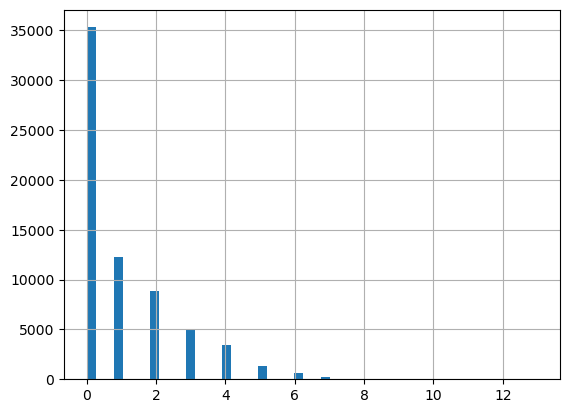

In [95]:
df['n_called_barcodes'].hist(bins=50)

In [96]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

In [97]:
adata_genes.obs['area']

object_id
1        12083.909039
2        12327.850827
3         6440.407723
4         4279.403177
7         5458.813969
             ...     
67193    13678.319345
67199     9246.990769
67200    10661.078562
67201     8041.815355
67202     6580.028514
Name: area, Length: 67202, dtype: float64

In [98]:
adata_genes.var_names

Index(['AKT1', 'AXL', 'BGN', 'BIRC3', 'BIRC5', 'BMP2', 'BMP4', 'CALD1', 'CAPG',
       'CCNA2',
       ...
       'TRPM1', 'TYR', 'VCAM1', 'VEGFA', 'VEGFC', 'VGF', 'WNT5A', 'YAP1',
       'ZEB1', 'ZEB2'],
      dtype='object', length=119)

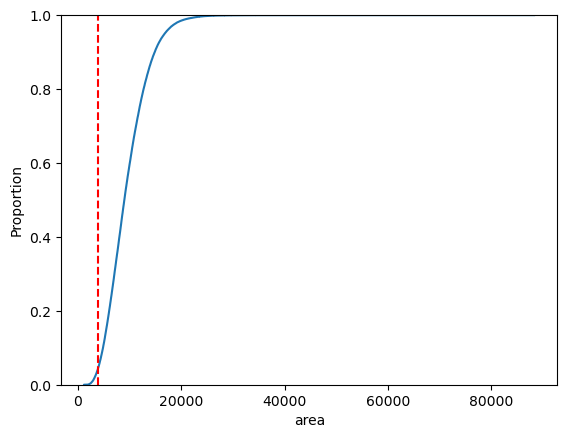

In [75]:
sns.ecdfplot(adata_genes.obs['area'],complementary=False)
plt.axvline(4000,color='red',linestyle='--')

In [76]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

(0.0, 20000.0)

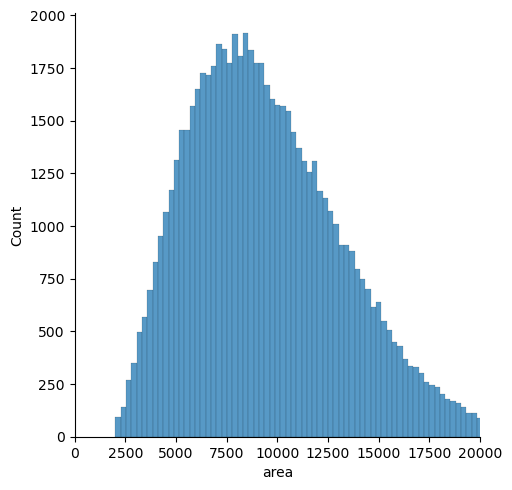

In [77]:
sns.displot(adata_genes.obs['area'])
plt.xlim(0,20000)

In [79]:
sc.pp.calculate_qc_metrics(adata_genes,percent_top=None,log1p=False,inplace=True)

In [80]:
adata_genes

AnnData object with n_obs × n_vars = 67174 × 120
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

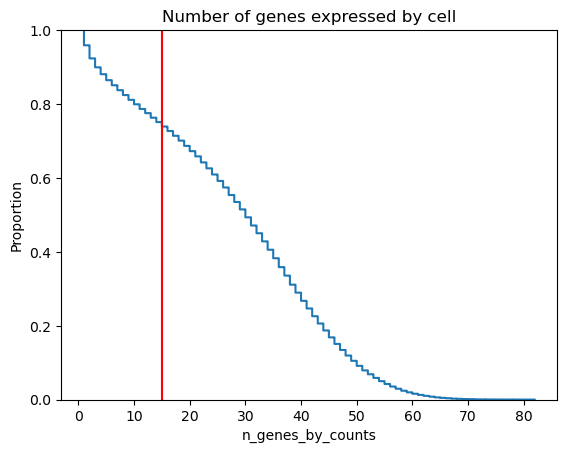

<Figure size 640x480 with 0 Axes>

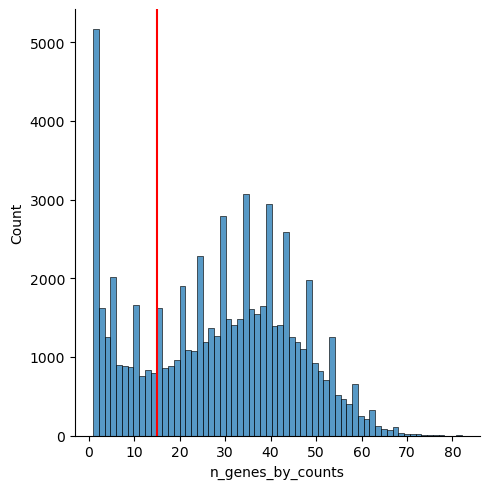

<Figure size 640x480 with 0 Axes>

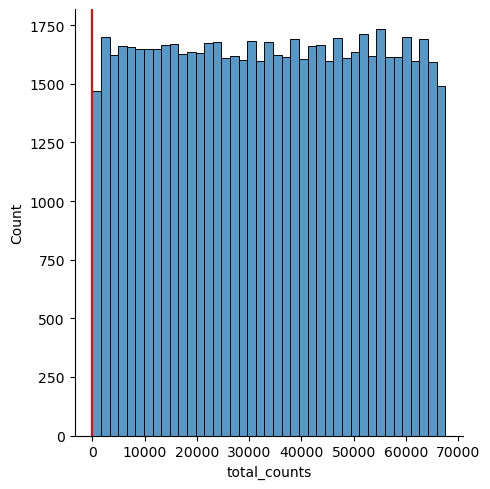

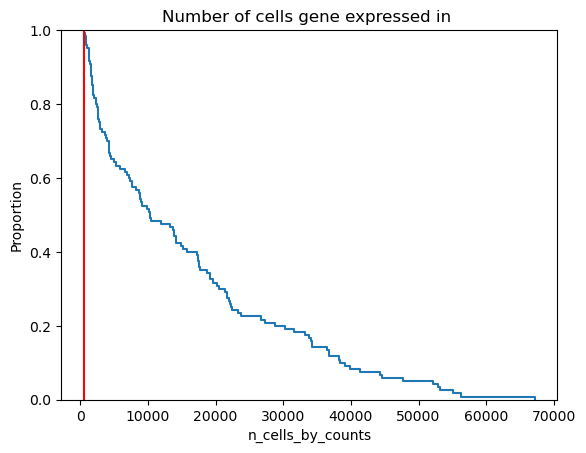

In [81]:


plt.figure()
plt.title('Number of genes expressed by cell')
sns.ecdfplot(adata_genes.obs['n_genes_by_counts'],complementary=True)
plt.axvline(15,color='r')
plt.figure()
sns.displot(adata_genes.obs['n_genes_by_counts'])
plt.axvline(15,color='r')


plt.figure()
sns.displot(adata_genes.obs['total_counts'])
plt.axvline(10,color='r')

plt.figure()
# sns.displot(adata_genes.var['n_cells_by_counts'])
plt.title('Number of cells gene expressed in ')
sns.ecdfplot(adata_genes.var['n_cells_by_counts'],complementary=True)
plt.axvline(500,color='r')

# plt.figure()
# sns.displot(adata_genes.obs['total_counts'])
# plt.axvline(10,color='r')



# sns.displot()

In [82]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=15) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

In [83]:
sc.pp.normalize_total(adata_genes) # normalize with total number of (non-barcode) spots per cell 
sc.pp.scale(adata_genes) # scale genes across cells

# sc.pp.highly_variable_genes(adata_genes, n_top_genes=30)

## seurat v3 normalization is applied to the counts directly, 
# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')
# sc.pp.highly_variable_genes(adata_genes, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat_v3')
# sc.pp.pca(adata_genes)

# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


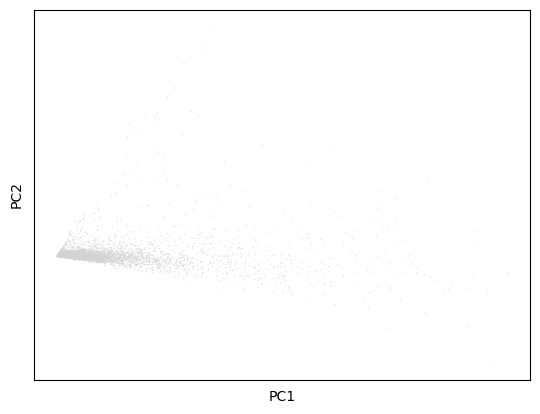

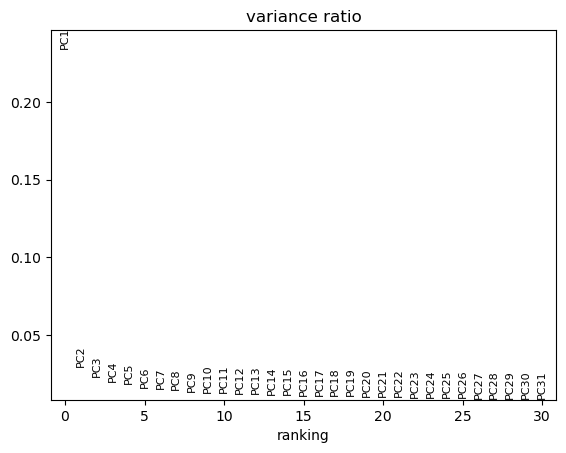

In [84]:
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [26]:
sc.pp.neighbors(adata_genes)
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


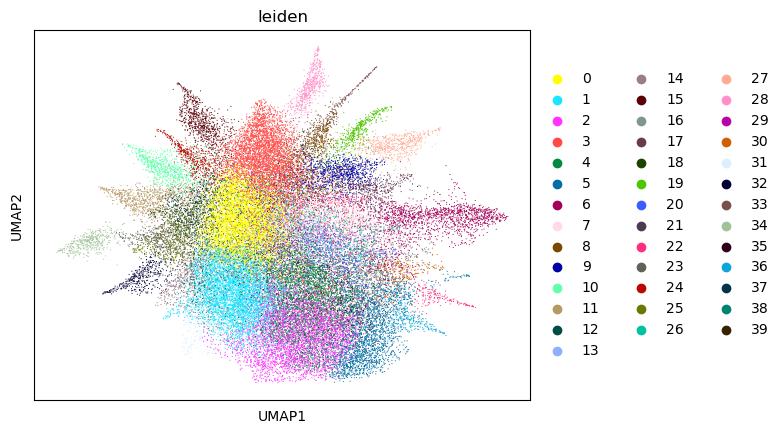

In [27]:
sc.pl.umap(adata_genes, color=["leiden"])

In [28]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [29]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


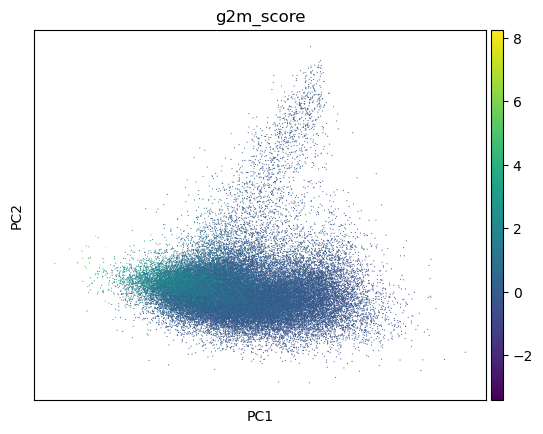

In [30]:
sc.pl.pca(adata_genes,color='g2m_score')

In [31]:
sc.pp.regress_out(adata_genes, ['g2m_score'])
sc.pp.scale(adata_genes)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


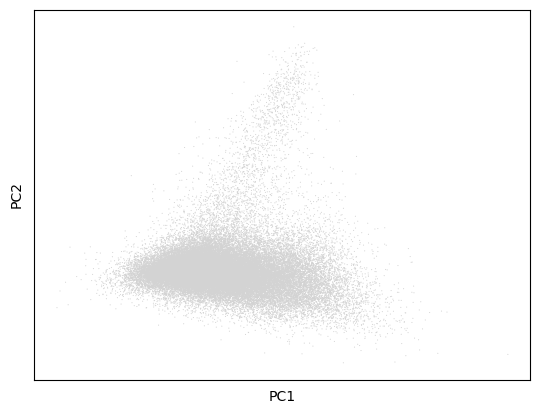

In [32]:
# I feel like this is supposed to be different after regressing out the cell cycle genes... 
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)

In [33]:
sc.pp.neighbors(adata_genes)
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
# sc.tl.leiden(adata_genes, n_iterations=-1)

In [34]:
res_list = [0.01,0.05,0.1,0.25, 0.5, 1.0]
for res in res_list:
    sc.tl.leiden(
        adata_genes, key_added=f"leiden_res_{res:4.2f}", resolution=res, random_state=42
    )


/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2

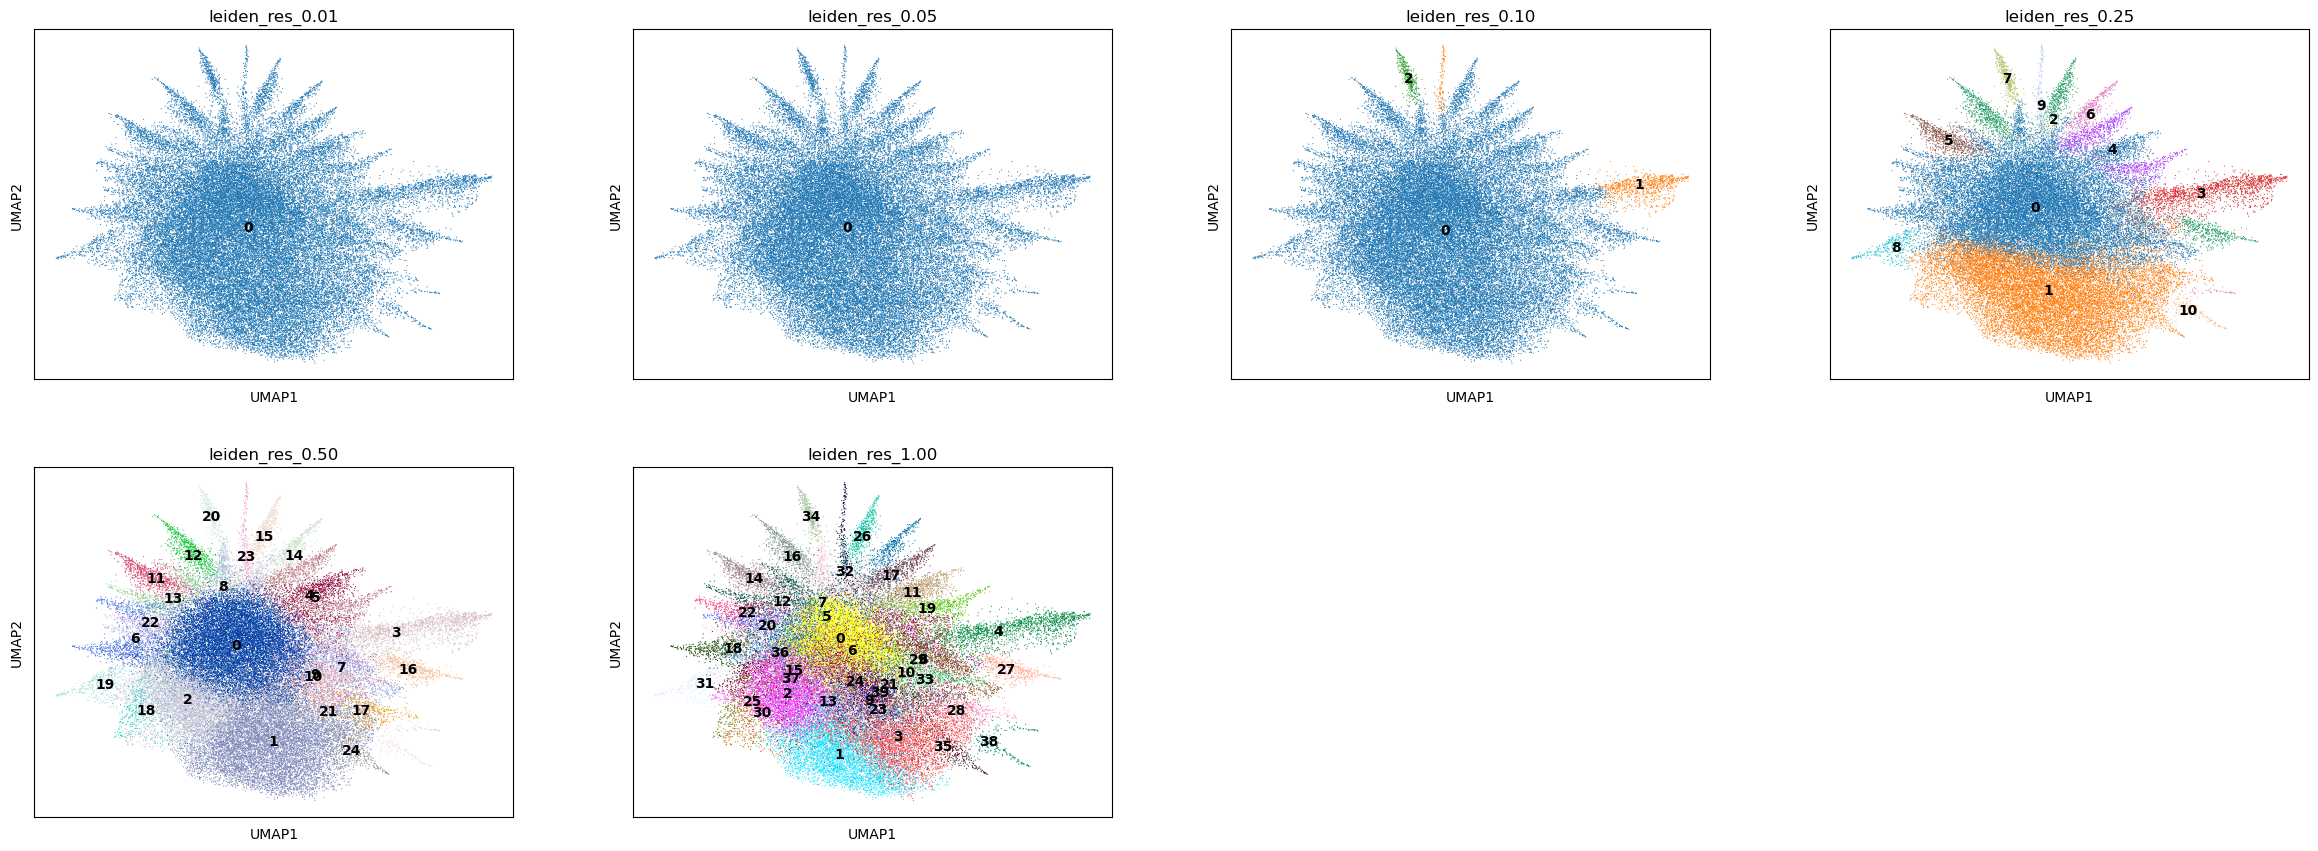

In [35]:
sc.pl.umap(
    adata_genes,
    color=[f"leiden_res_{res:4.2f}" for res in res_list],
    legend_loc="on data",
)

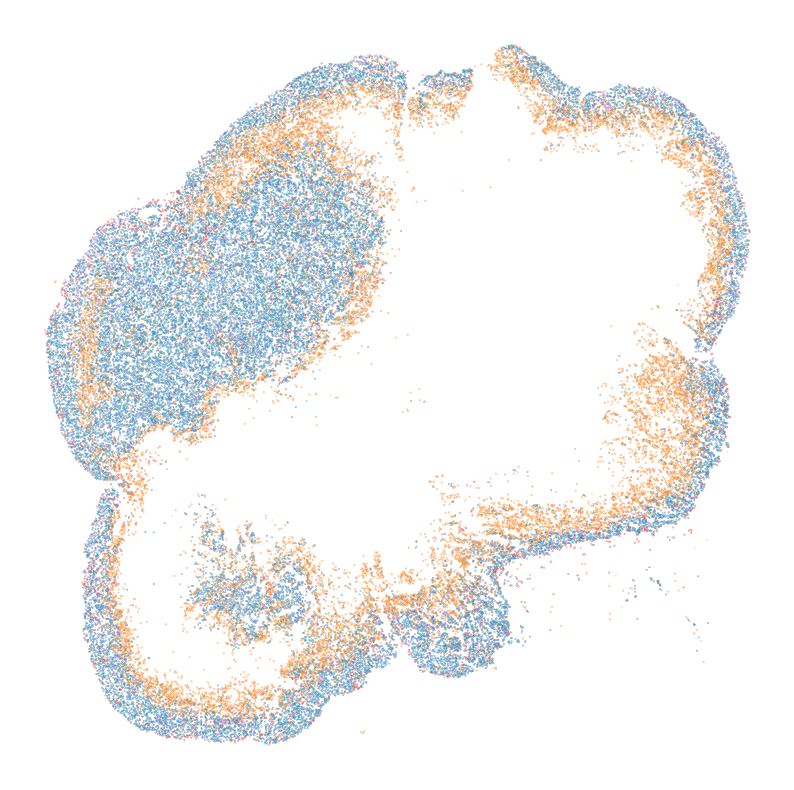

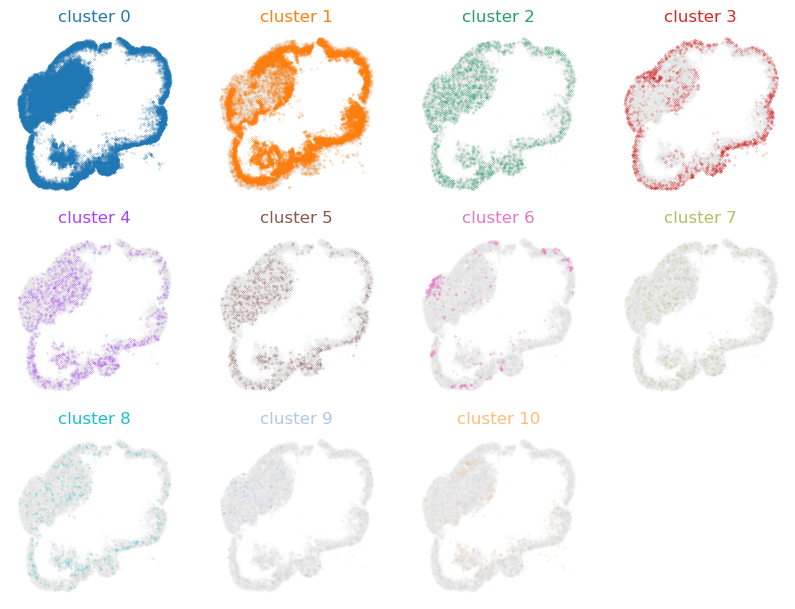

In [36]:
res_to_use = 0.25

c_dict = {str(x):c for x,c in enumerate(adata_genes.uns[f'leiden_res_{res_to_use:4.2f}_colors'])}
c_list =[c_dict[x] for x in adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']]

fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
            c=c_list,
            s=0.2)
plt.axis('off')

plt.figure(figsize=(10,10))
for cluster in np.unique(adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']):
    plt.subplot(4,4,int(cluster)+1)
    plt.title(f'cluster {cluster}',color=c_dict[str(cluster)])
    not_cluster = adata_genes[adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']!=str(cluster)]
    plt.scatter(not_cluster.obs['center_x'],not_cluster .obs['center_y'],marker='.',
                c='gray',
                s=0.1,alpha=0.01)
    
    this_cluster = adata_genes[adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']==str(cluster)]
    plt.scatter(this_cluster.obs['center_x'],this_cluster.obs['center_y'],marker='.',
                c=c_dict[str(cluster)],
                s=0.1)
    plt.axis('off')
    

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages

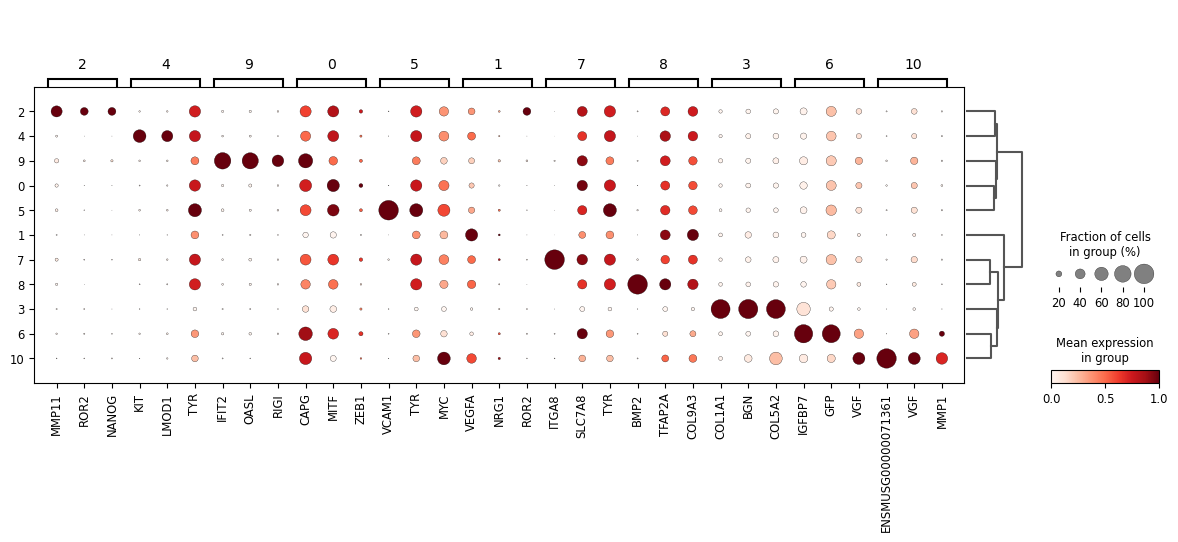

In [37]:
sc.tl.rank_genes_groups(adata_genes, groupby=f"leiden_res_{res_to_use:4.2f}", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata_genes, groupby=f"leiden_res_{res_to_use:4.2f}", standard_scale="var", n_genes=3
)

In [100]:
adata_genes[adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']=='6'].obs['barcode_names']

KeyError: 'leiden_res_0.25'

In [39]:
min_number_barcodes = 1

name,count = np.unique(adata_genes.obs[adata_genes.obs['n_called_barcodes']>=min_number_barcodes]['barcode_names'].values,return_counts=True)

common_bc_combos = {}

min_number_cells = 10

for n,c in zip(name,count):
    if c > min_number_cells:
        # print(n,c)
        common_bc_combos[n] = c
    # print(n,c)  


(-648.8675447522292, 59258.76371243313, -771.1445560851262, 48869.84452242345)

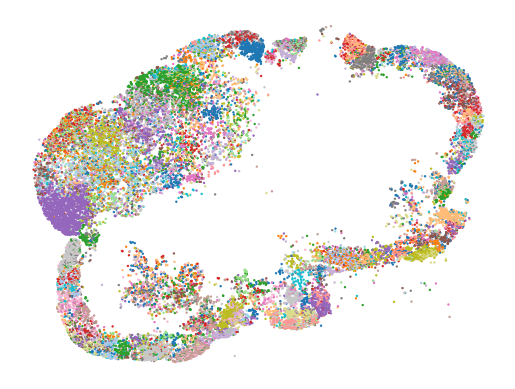

In [40]:
bc_colors = sns.color_palette('tab20',n_colors=len(common_bc_combos))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(common_bc_combos.keys())}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.0)  for bc in adata_genes.obs['barcode_names'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)


plt.axis('off')

There are some pockets of cells that appear to have mixed barcode identities - are these real or just doubleets?

In [41]:
# top 16 barcodes:
min_number_barcodes = 3
name,count = np.unique(adata_genes.obs[adata_genes.obs['n_called_barcodes']>=min_number_barcodes]['barcode_names'].values,return_counts=True)

very_common_bcs = name[np.argsort(count)[::-1][:16]]

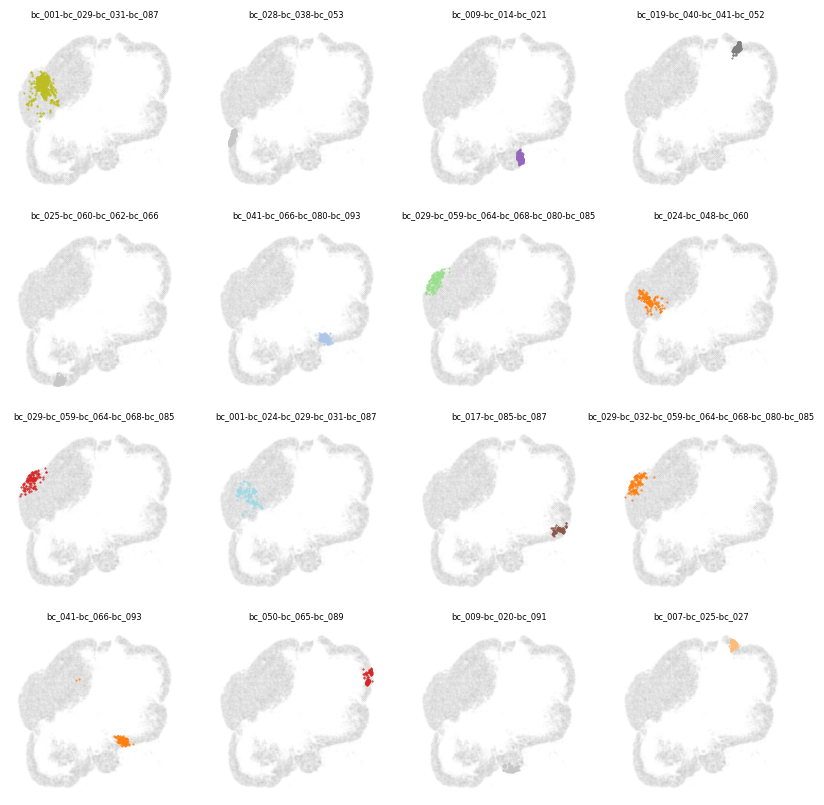

In [42]:
# very_common_bcs = ['bc_001-bc_024-bc_029-bc_031-bc_087',
#  'bc_001-bc_029-bc_031-bc_087',
#  'bc_007-bc_025-bc_027',
#  'bc_009-bc_014-bc_021',
#  'bc_009-bc_020-bc_091',
#  'bc_017-bc_085-bc_087',
#  'bc_019-bc_040-bc_041-bc_052',
#  'bc_024-bc_048-bc_060',
#  'bc_025-bc_060-bc_062-bc_066',
#  'bc_028-bc_038-bc_053',
#  'bc_029-bc_032-bc_059-bc_064-bc_068-bc_080-bc_085',
#  'bc_029-bc_059-bc_064-bc_068-bc_080-bc_085',
#  'bc_029-bc_059-bc_064-bc_068-bc_085',
#  'bc_041-bc_066-bc_080-bc_093',
#  'bc_041-bc_066-bc_093',
#  'bc_050-bc_065-bc_089']

plt.figure(figsize=(10,10))
for i,bc_name in enumerate(very_common_bcs):
    
    plt.subplot(4,4,i+1)
    plt.title(bc_name,fontsize=6)

    others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
            color=bc_color_dict[bc_name],alpha=1.0,
            s=0.25)
    
    plt.axis('off')
    

In [43]:
adata_genes.obs['_id'] 

KeyError: '_id'

In [44]:
def get_polygons_around_polygon(sg_obj,identifier,id_field='object_id',image_scale=5):

    polygon_gdf = sg_obj.gdf[sg_obj.gdf[id_field] == identifier]

    first_polygon_geometry = polygon_gdf.geometry.iloc[0]

    minx, miny, maxx, maxy = first_polygon_geometry.bounds
    dx = (maxx - minx) * 0.5 * image_scale
    dy = (maxy - miny) * 0.5 * image_scale
    expanded_bbox = box(minx - dx, miny - dy, maxx + dx, maxy + dy)

    other_polygons = sg_obj.gdf[sg_obj.gdf.geometry.intersects(expanded_bbox) & (sg_obj.gdf[id_field] != identifier)]

    return other_polygons

def get_polygon_barcodes(df,identifier,id_field='cell_id'):

    if len(df[df[id_field]==identifier]['called_barcodes'].values) > 0:

        return df[df[id_field]==identifier]['called_barcodes'].values[0]

    else:
        return []

def get_all_barcodes_in_region(df,identifiers,id_field='cell_id'):

    bc_list = []

    for identifier in identifiers:
        bc_list += get_polygon_barcodes(df,identifier,id_field=id_field)

    return bc_list



In [45]:
sg_obj.gdf['object_id'] = sg_obj.gdf.index

In [46]:
# Let's unpack the bc041-bc066-bc093 barcode combo which is next to a bunch of bc041-bc066-bc080-bc093 cells and see what's going on there
entries_here = df[df['barcode_names'].isin([
    'bc_001-bc_024-bc_029-bc_031-bc_087',
                            #  'bc_001-bc_031-bc_087'
                             ])][['bc_001','bc_024','bc_029','bc_031','bc_087']]



In [53]:
# df[df['barcode_names'].isin([
#     'bc_001-bc024-bc_029-bc_031-bc_087',
#                             #  'bc_001-bc_031-bc_087'
#                              ])]

In [54]:
# Let's unpack the bc041-bc066-bc093 barcode combo which is next to a bunch of bc041-bc066-bc080-bc093 cells and see what's going on there
entries_here = df[df['barcode_names'].isin([
    'bc_001-bc_029-bc_031-bc_087',
                            #  'bc_001-bc_031-bc_087'
                             ])][['bc_001','bc_029','bc_031','bc_087']]



In [55]:
np.mean(entries_here,axis=0)

bc_001    13.651119
bc_029     8.141791
bc_031    14.727612
bc_087    24.093283
dtype: float32

In [56]:
np.sum(entries_here,axis=0)/np.sum(entries_here.values,axis=None)

bc_001    0.225215
bc_029    0.134322
bc_031    0.242975
bc_087    0.397488
dtype: float32

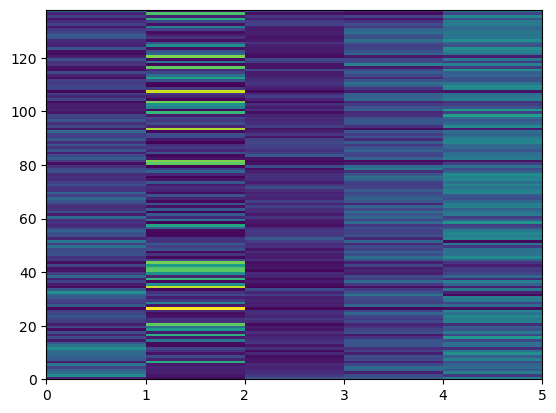

In [52]:
plt.pcolormesh(entries_here.values/np.sum(entries_here.values,axis=1)[:,np.newaxis])



In [53]:
bc_list = ['bc_001','bc_024','bc_029','bc_031','bc_087']

# import  as comb
bcs_here = []
bcs_here.append('-'.join(bc_list))
for c in itertools.combinations(bc_list,4):
    bcs_here.append('-'.join(c))

for c in itertools.combinations(bc_list,3):
    bcs_here.append('-'.join(c))

for c in itertools.combinations(bc_list,2):
    bcs_here.append('-'.join(c))

for c in itertools.combinations(bc_list,1):
    bcs_here.append('-'.join(c))

plt.figure(figsize=(2*5,2*8))
for i,bc_name in enumerate(bcs_here):
    
    # plt.subplot(6,6,i+1)
    if i == 0:
        plt.subplot(8,5,i+1)
    else:
        plt.subplot(8,5,i+5)
    plt.title(bc_name,fontsize=6)

    others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
            color='k',alpha=1.0,
            s=0.25)
    
    plt.axis('off')

NameError: name 'itertools' is not defined

In [74]:
sg_obj.gdf

nucleus  \
object_id                                                      
1          POLYGON ((23727.000 1097.000, 23741.000 1098.0...   
2          POLYGON ((23811.000 1166.000, 23822.000 1166.0...   
3          POLYGON ((19383.000 1449.000, 19398.000 1451.0...   
4          POLYGON ((19107.000 1506.000, 19137.000 1507.0...   
7          POLYGON ((15238.000 1549.000, 15252.000 1549.0...   
...                                                      ...   
67193      POLYGON ((37771.000 46466.000, 37777.000 46470...   
67199      POLYGON ((38215.000 46546.000, 38237.000 46547...   
67200      POLYGON ((38366.000 46565.000, 38403.000 46566...   
67201      POLYGON ((38105.000 46579.000, 38137.000 46586...   
67202      POLYGON ((38499.000 46598.000, 38524.000 46598...   

                                             nucleus_dilated  \
object_id                                                      
1          POLYGON ((23723.193 1087.753, 23706.193 1094.7...   
2          POLYGON ((23807.286 1156.715, 23797.286 1160.7...   
3          POLYGON ((19378.528 1440.056, 19352.528 1453.0...   
4          POLYGON ((19091.029 1530.598, 19090.693 1531.3...   
7          POLYGON ((15236.760 1539.077, 15220.760 1541.0...   
...                                                      ...   
67193      POLYGON ((37765.537 46457.624, 37742.537 46472...   
67199      POLYGON ((38212.441 46536.333, 38179.699 46545...   
67200      POLYGON ((38364.157 46555.171, 38332.157 46561...   
67201      POLYGON ((38099.855 46570.425, 38096.394 46572...   
67202      POLYGON ((38496.253 46588.385, 38490.858 46589...   

                      nucleus_centroid      center_x      center_y  \
object_id                                                            
1           POINT (23747.880 1155.889)  23747.879606   1155.889230   
2           POINT (23806.278 1229.866)  23806.277927   1229.866352   
3           POINT (19365.232 1485.264)  19365.232060   1485.264038   
4           POINT (19129.721 1524.719)  19129.720568   1524.718822   
7           POINT (15196.783 1575.083)  15196.782900   1575.083015   
...                                ...           ...           ...   
67193      POINT (37783.462 46544.912)  37783.462010  46544.912100   
67199      POINT (38208.404 46576.996)  38208.404034  46576.996025   
67200      POINT (38384.677 46598.134)  38384.676549  46598.133528   
67201      POINT (38113.042 46613.436)  38113.042241  46613.435928   
67202      POINT (38503.604 46624.955)  38503.603601  46624.954506   

                   area  
object_id                
1          12083.909039  
2          12327.850827  
3           6440.407723  
4           4279.403177  
7           5458.813969  
...                 ...  
67193      13678.319345  
67199       9246.990769  
67200      10661.078562  
67201       8041.815355  
67202       6580.028514  

[67202 rows x 6 columns]

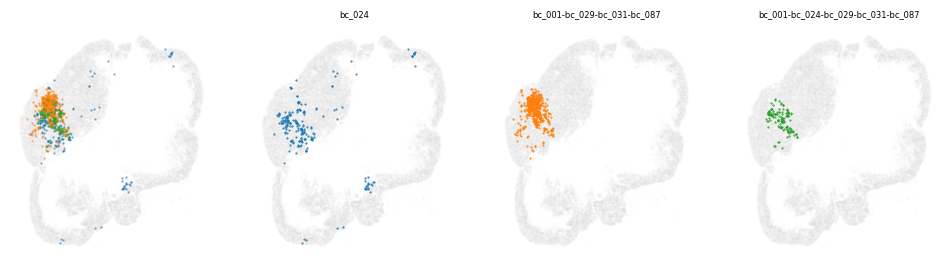

In [54]:
bcs_here = ['bc_024','bc_001-bc_029-bc_031-bc_087','bc_001-bc_024-bc_029-bc_031-bc_087',]

color_list = ['b','r','purple']

plt.figure(figsize=(3*4,1*3))

plt.subplot(1,4,1)
# plt.title(bc_name,fontsize=6)

others = adata_genes[~adata_genes.obs['barcode_names'].isin(bcs_here)]
plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
        color='gray',alpha=0.01,
        s=0.1)


for i,bc_name in enumerate(bcs_here):
    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
            color=sns.color_palette()[i],alpha=0.5,
            s=0.5)

plt.axis('off')


for i,bc_name in enumerate(bcs_here):
    
    plt.subplot(1,4,i+2)
    # if i == 0:
    #     plt.subplot(8,5,i+1)
    # else:
    #     plt.subplot(8,5,i+5)
    plt.title(bc_name,fontsize=6)

    others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
            color=sns.color_palette()[i],alpha=1.0,
            s=0.25)
    
    plt.axis('off')



In [51]:
adata_genes.obs[adata_genes.obs['barcode_names'].isin([
    'bc_001-bc_024-bc_029-bc_031-bc_087'])]

cell_id  n_called_barcodes                       barcode_names  \
object_id                                                                  
29564       29564                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
30051       30051                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
30324       30324                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
31579       31579                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
31734       31734                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
...           ...                ...                                 ...   
45816       45816                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
45991       45991                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
46484       46484                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
46943       46943                  5  bc_001-bc_024-bc_029-bc_031-bc_087   
47224       47224                  5  bc_001-bc_024-bc_029-bc_031-bc_087   

                                    called_barcodes          area  \
object_id                                                           
29564      [bc_001, bc_024, bc_029, bc_031, bc_087]  12856.921973   
30051      [bc_001, bc_024, bc_029, bc_031, bc_087]  10433.767761   
30324      [bc_001, bc_024, bc_029, bc_031, bc_087]   9487.642970   
31579      [bc_001, bc_024, bc_029, bc_031, bc_087]  11704.779091   
31734      [bc_001, bc_024, bc_029, bc_031, bc_087]   7285.985345   
...                                             ...           ...   
45816      [bc_001, bc_024, bc_029, bc_031, bc_087]  14214.875896   
45991      [bc_001, bc_024, bc_029, bc_031, bc_087]   5602.493374   
46484      [bc_001, bc_024, bc_029, bc_031, bc_087]  20750.813384   
46943      [bc_001, bc_024, bc_029, bc_031, bc_087]  16256.340345   
47224      [bc_001, bc_024, bc_029, bc_031, bc_087]  12096.917247   

               center_x      center_y  n_genes_by_counts  total_counts  \
object_id                                                                
29564      12391.086484  22480.543334                NaN           NaN   
30051      10001.705307  22800.068966                NaN           NaN   
30324      10267.698952  22952.495273                NaN           NaN   
31579      11529.930717  23711.632916                NaN           NaN   
31734      11192.661804  23811.705568                NaN           NaN   
...                 ...           ...                ...           ...   
45816      12292.355578  32067.612981                NaN           NaN   
45991       9098.710343  32139.687934                NaN           NaN   
46484      11670.624486  32469.325362                NaN           NaN   
46943      10511.031298  32698.888208                NaN           NaN   
47224      10311.449094  32868.775734                NaN           NaN   

           n_genes leiden  g2m_score leiden_res_0.01 leiden_res_0.05  \
object_id                                                              
29564           48     23  -0.274710               0               0   
30051           43      0   0.339300               0               0   
30324           36     38  -0.120228               0               0   
31579           38     21  -0.185168               0               0   
31734           30      0  -0.328186               0               0   
...            ...    ...        ...             ...             ...   
45816           60      9  -0.355308               0               0   
45991           40      7  -0.315256               0               0   
46484           63      3   1.337124               0               0   
46943           58      0  -0.315849               0               0   
47224           38      8   1.085569               0               0   

          leiden_res_0.10 leiden_res_0.25 leiden_res_0.50 leiden_res_1.00  
object_id                                                                  
29564                   0               0               0              

In [79]:
sg_obj.gdf

nucleus  \
object_id                                                      
1          POLYGON ((23727.000 1097.000, 23741.000 1098.0...   
2          POLYGON ((23811.000 1166.000, 23822.000 1166.0...   
3          POLYGON ((19383.000 1449.000, 19398.000 1451.0...   
4          POLYGON ((19107.000 1506.000, 19137.000 1507.0...   
7          POLYGON ((15238.000 1549.000, 15252.000 1549.0...   
...                                                      ...   
67193      POLYGON ((37771.000 46466.000, 37777.000 46470...   
67199      POLYGON ((38215.000 46546.000, 38237.000 46547...   
67200      POLYGON ((38366.000 46565.000, 38403.000 46566...   
67201      POLYGON ((38105.000 46579.000, 38137.000 46586...   
67202      POLYGON ((38499.000 46598.000, 38524.000 46598...   

                                             nucleus_dilated  \
object_id                                                      
1          POLYGON ((23723.193 1087.753, 23706.193 1094.7...   
2          POLYGON ((23807.286 1156.715, 23797.286 1160.7...   
3          POLYGON ((19378.528 1440.056, 19352.528 1453.0...   
4          POLYGON ((19091.029 1530.598, 19090.693 1531.3...   
7          POLYGON ((15236.760 1539.077, 15220.760 1541.0...   
...                                                      ...   
67193      POLYGON ((37765.537 46457.624, 37742.537 46472...   
67199      POLYGON ((38212.441 46536.333, 38179.699 46545...   
67200      POLYGON ((38364.157 46555.171, 38332.157 46561...   
67201      POLYGON ((38099.855 46570.425, 38096.394 46572...   
67202      POLYGON ((38496.253 46588.385, 38490.858 46589...   

                      nucleus_centroid      center_x      center_y  \
object_id                                                            
1           POINT (23747.880 1155.889)  23747.879606   1155.889230   
2           POINT (23806.278 1229.866)  23806.277927   1229.866352   
3           POINT (19365.232 1485.264)  19365.232060   1485.264038   
4           POINT (19129.721 1524.719)  19129.720568   1524.718822   
7           POINT (15196.783 1575.083)  15196.782900   1575.083015   
...                                ...           ...           ...   
67193      POINT (37783.462 46544.912)  37783.462010  46544.912100   
67199      POINT (38208.404 46576.996)  38208.404034  46576.996025   
67200      POINT (38384.677 46598.134)  38384.676549  46598.133528   
67201      POINT (38113.042 46613.436)  38113.042241  46613.435928   
67202      POINT (38503.604 46624.955)  38503.603601  46624.954506   

                   area cell_id  
object_id                        
1          12083.909039       1  
2          12327.850827       2  
3           6440.407723       3  
4           4279.403177       4  
7           5458.813969       7  
...                 ...     ...  
67193      13678.319345   67193  
67199       9246.990769   67199  
67200      10661.078562   67200  
67201       8041.815355   67201  
67202       6580.028514   67202  

[67202 rows x 7 columns]

In [76]:
sg_obj.gdf['cell_id'] = sg_obj.gdf.index

10433.76776107144


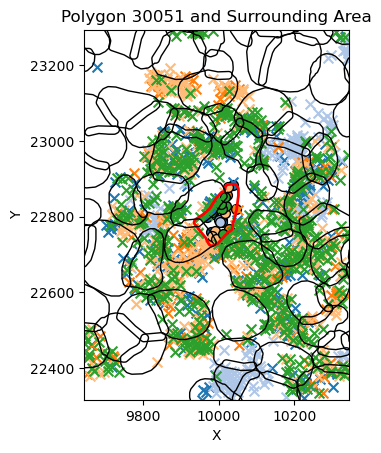

14214.875895915842


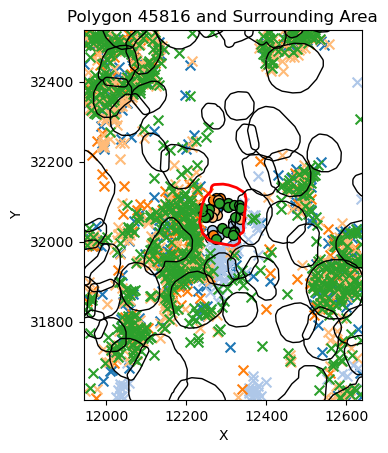

7285.98534451013


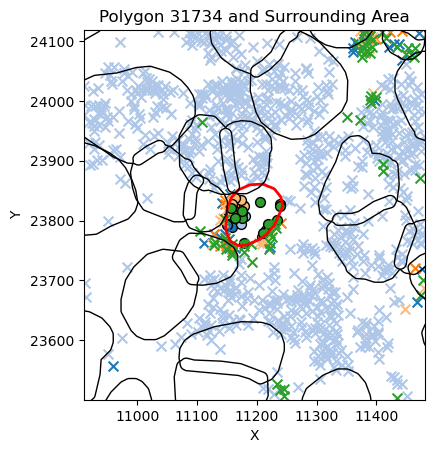

12096.917246945322


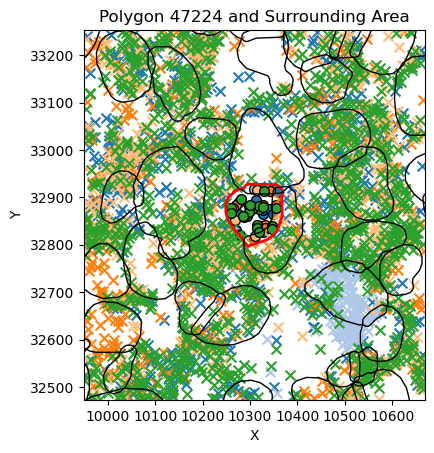

20750.81338438458


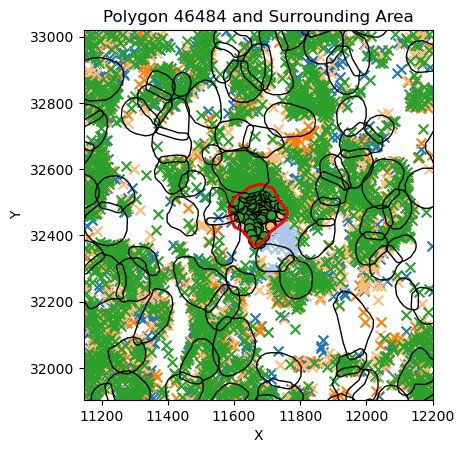

In [52]:
for cell_id in ['30051','45816','31734','47224','46484']:
    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    print(df[df['cell_id']==cell_id]['area'].values[0])

    # region = get_polygons_around_polygon(sg_obj,cell_id,image_scale=10)

    # gene_names = [    'bc_001','bc_029','bc_031','bc_087']

    # gene_names = ['bc_029']
    gene_names = ['bc_001','bc_024','bc_029','bc_031','bc_087']


    # gene_names = ['bc_024']
        # 'bc_001','bc_029','bc_031','bc_087'



    # gene_names = get_all_barcodes_in_region(df,region['object_id'].values)
    # gene_names.append('SOX10')

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    sg_obj.plot_polygon_and_points(cell_id,gene_names=gene_names,annotate=False,image_scale=5)
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

KeyError: 'cell_id'

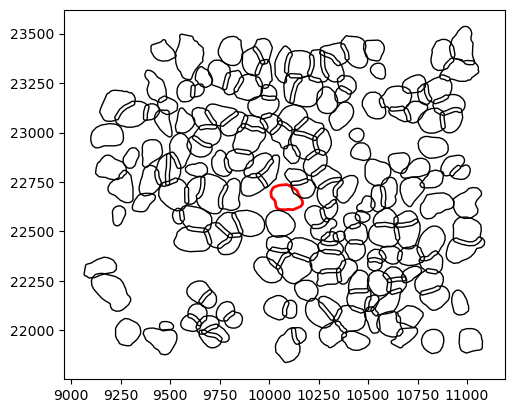

In [82]:
for cell_id in ['29871','27575','32002','31604','49118']:
    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    # print(df[df['cell_id']==cell_id]['area'].values[0])

    # region = get_polygons_around_polygon(sg_obj,cell_id,image_scale=100)

    # gene_names = [    'bc_001','bc_029','bc_031','bc_087']

    gene_names = ['bc_029']
        # 'bc_001','bc_029','bc_031','bc_087'



    # gene_names = get_all_barcodes_in_region(df,region['object_id'].values)
    # gene_names.append('SOX10')

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    sg_obj.plot_polygon_and_points(cell_id,gene_names=gene_names,annotate=False,image_scale=10,id_field='cell_id')
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

15274.585523786


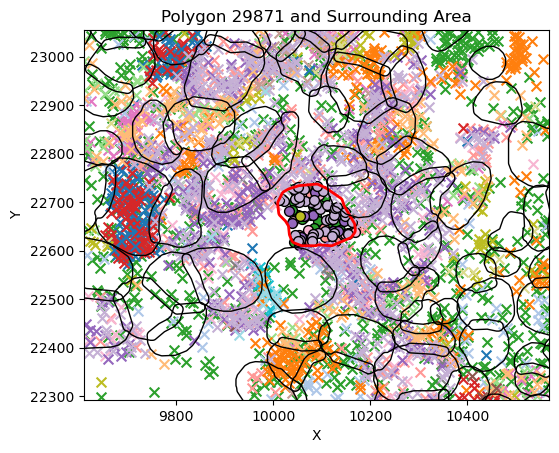

7231.212595232456


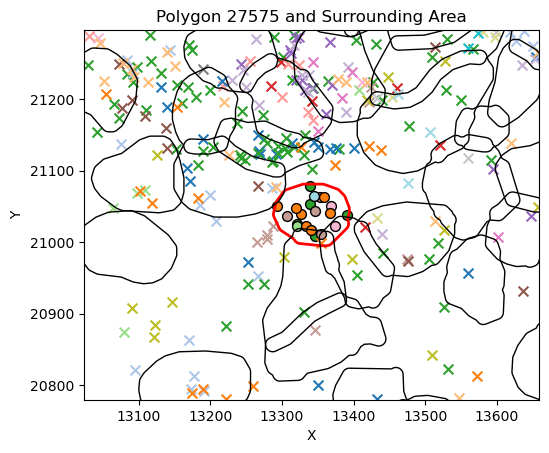

9646.975823093984


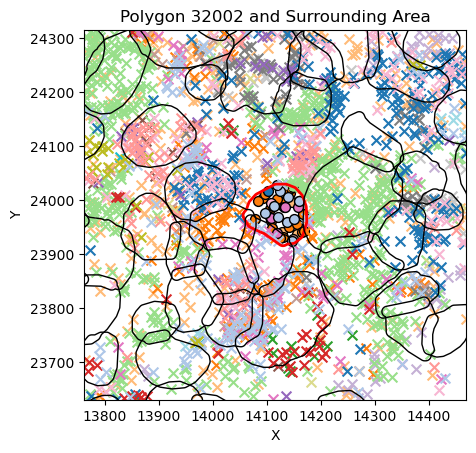

5402.674845402758


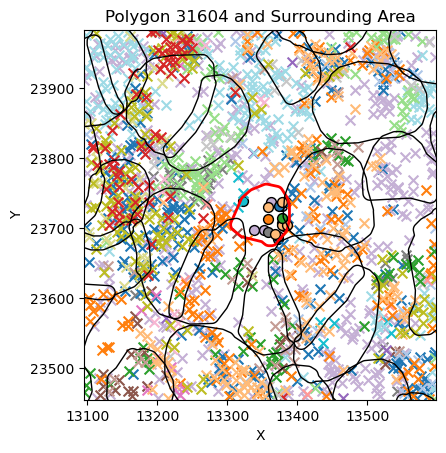

In [185]:
for cell_id in ['29871','27575','32002','31604']:
    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    print(df[df['cell_id']==cell_id]['area'].values[0])

    region = get_polygons_around_polygon(sg_obj,cell_id,image_scale=5)

    gene_names = ['bc_041','bc_066','bc_080','bc_093','SOX10']

    gene_names = get_all_barcodes_in_region(df,region['object_id'].values)
    gene_names.append('SOX10')

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    sg_obj.plot_polygon_and_points(cell_id,gene_names=gene_names,annotate=False,image_scale=5)
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

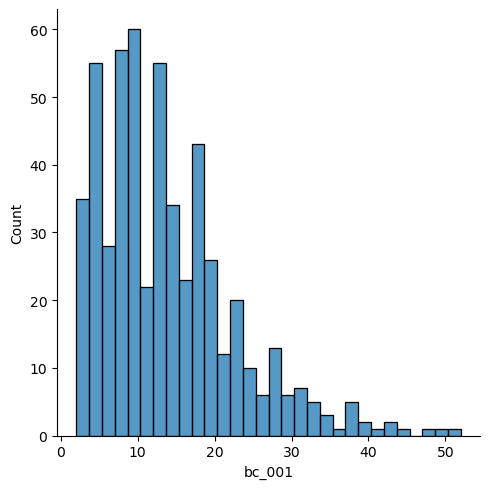

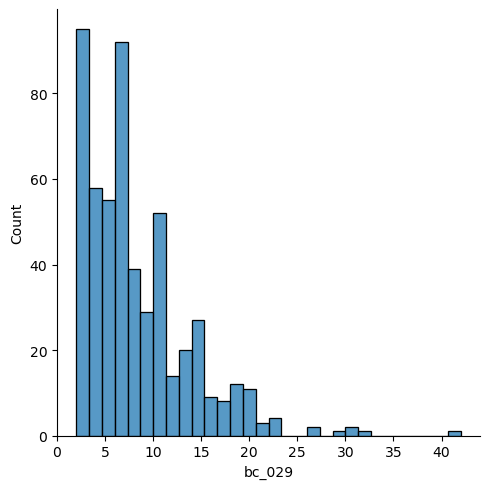

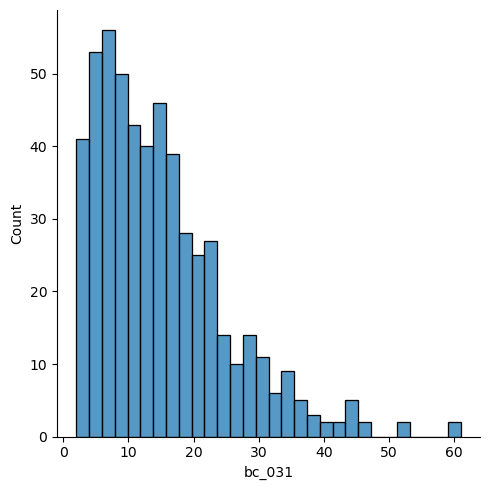

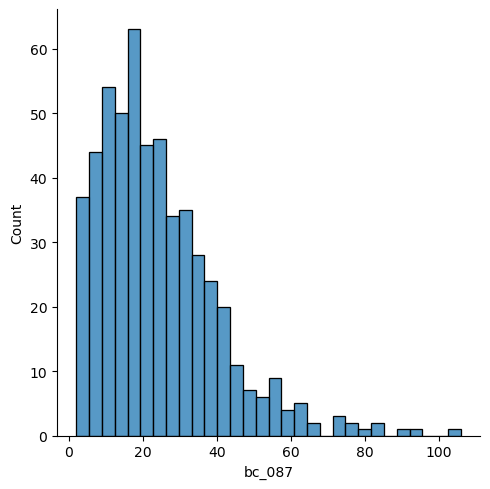

In [65]:
correctly_found = adata_genes.obs[adata_genes.obs['barcode_names'].isin([
    'bc_001-bc_029-bc_031-bc_087'])]['cell_id'].values

bc_list = ['bc_001','bc_029','bc_031','bc_087']
for bc in bc_list:
    sns.displot(df[df['cell_id'].isin(correctly_found)][bc],bins=30)


In [58]:
adata_genes.obs[adata_genes.obs['barcode_names'].isin([
    'bc_001-bc_031-bc_087'])]

cell_id  n_called_barcodes         barcode_names  \
object_id                                                    
27575       27575                  3  bc_001-bc_031-bc_087   
30163       30163                  3  bc_001-bc_031-bc_087   
31604       31604                  3  bc_001-bc_031-bc_087   
32002       32002                  3  bc_001-bc_031-bc_087   
33548       33548                  3  bc_001-bc_031-bc_087   
...           ...                ...                   ...   
49118       49118                  3  bc_001-bc_031-bc_087   
49381       49381                  3  bc_001-bc_031-bc_087   
49743       49743                  3  bc_001-bc_031-bc_087   
50006       50006                  3  bc_001-bc_031-bc_087   
50130       50130                  3  bc_001-bc_031-bc_087   

                    called_barcodes          area      center_x      center_y  \
object_id                                                                       
27575      [bc_001, bc_031, bc_087]   7231.212595  13342.538047  21039.330527   
30163      [bc_001, bc_031, bc_087]   7225.559118  11123.323021  22830.067282   
31604      [bc_001, bc_031, bc_087]   5402.674845  13351.074080  23719.160682   
32002      [bc_001, bc_031, bc_087]   9646.975823  14121.476876  23975.224758   
33548      [bc_001, bc_031, bc_087]   5836.715076  16651.381151  24891.331351   
...                             ...           ...           ...           ...   
49118      [bc_001, bc_031, bc_087]   8929.192248  11961.550973  34026.117058   
49381      [bc_001, bc_031, bc_087]   9187.150848   9975.787002  34178.679823   
49743      [bc_001, bc_031, bc_087]  18947.806126  11745.552544  34417.158836   
50006      [bc_001, bc_031, bc_087]   8162.673667  10271.334480  34539.838707   
50130      [bc_001, bc_031, bc_087]  11302.049225  12266.408974  34624.564257   

           n_genes_by_counts  total_counts  n_genes leiden  g2m_score  \
object_id                                                               
27575                    NaN           NaN       32     30   1.077337   
30163                    NaN           NaN       30      0  -0.670874   
31604                    NaN           NaN       30     10   0.159396   
32002                    NaN           NaN       38     24  -0.261644   
33548                    NaN           NaN       18      2   0.225386   
...                      ...           ...      ...    ...        ...   
49118                    NaN           NaN       50      5   0.504875   
49381                    NaN           NaN       38     12   0.196116   
49743                    NaN           NaN       63      0   0.196747   
50006                    NaN           NaN       52     15   1.071062   
50130                    NaN           NaN       29      6  -0.198814   

          leiden_res_0.01 leiden_res_0.05 leiden_res_0.10 leiden_res_0.25  \
object_id                                                                   
27575                   0               0               0               1   
30163                   0               0               0               0   
31604                   0               0               0               5   
32002                   0               0               0               0   
33548                   0               0               0               0   
...                   ...             ...             ...             ...   
49118                   0               0               0               1   
49381                   0               0               0               0   
49743                   0               0               0               0   
50006                   0               0               0               2   
50130                   0               0               1               3   

          leiden_res_0.50 leiden_res_1.00  
object_id                                  
27575                  17              28  
30163                   0               6  
31604                

7225.559118143488


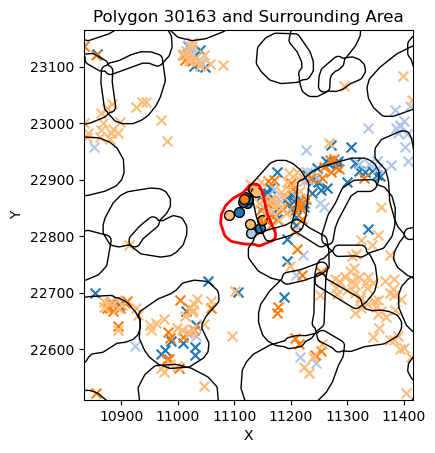

8162.6736670202545


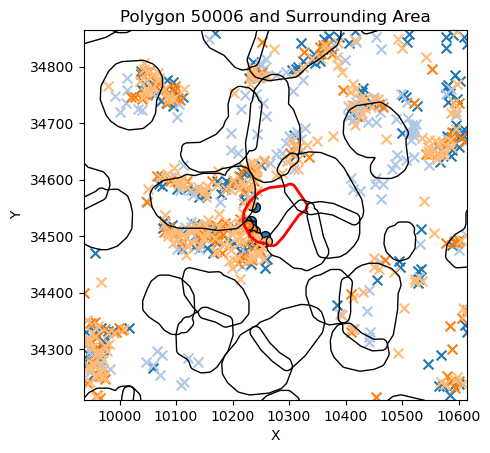

5836.715075873082


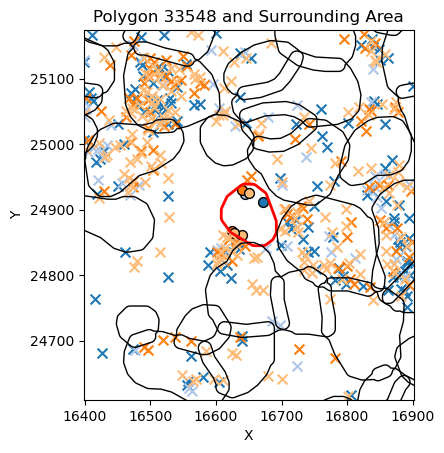

18947.80612600914


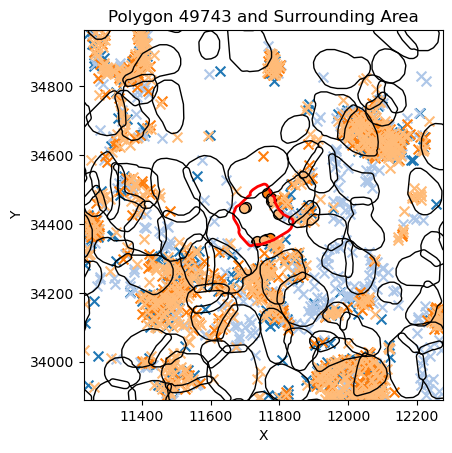

8929.192247640298


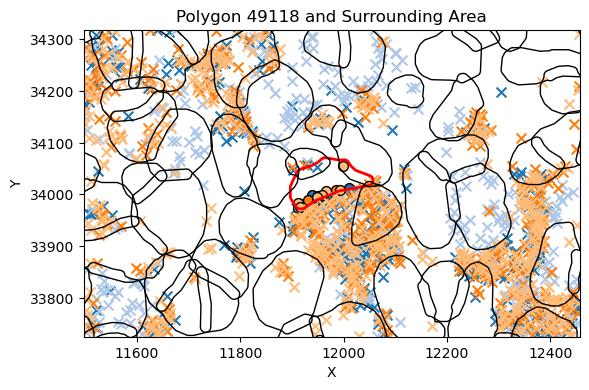

In [63]:
for cell_id in ['30163','50006','33548','49743','49118']:
    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    # print(df[df['cell_id']==cell_id]['area'].values[0])
    # print(adata_genes.obs.loc[cell_id]['total_counts']) 

    print(df[df['cell_id']==cell_id]['area'].values[0])

    # region = get_polygons_around_polygon(sg_obj,cell_id,image_scale=10)

    # gene_names = [    'bc_001','bc_029','bc_031','bc_087']

    # gene_names = ['bc_029']
    gene_names = ['bc_001','bc_029','bc_031','bc_087']


    # gene_names = ['bc_024']
        # 'bc_001','bc_029','bc_031','bc_087'



    # gene_names = get_all_barcodes_in_region(df,region['object_id'].values)
    # gene_names.append('SOX10')

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    sg_obj.plot_polygon_and_points(cell_id,gene_names=gene_names,annotate=False,image_scale=5)
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [155]:
# Let's unpack the bc041-bc066-bc093 barcode combo which is next to a bunch of bc041-bc066-bc080-bc093 cells and see what's going on there
df[df['barcode_names'].isin(['bc_041-bc_066-bc_093','bc_041-bc_066-bc_080-bc_093'])][['barcode_names','bc_041','bc_066','bc_080','bc_093']]

barcode_names  bc_041  bc_066  bc_080  bc_093
object_id                                                             
17598             bc_041-bc_066-bc_093     3.0     3.0     1.0     3.0
17632             bc_041-bc_066-bc_093     7.0     6.0     1.0     8.0
17675      bc_041-bc_066-bc_080-bc_093    12.0     2.0     3.0     5.0
17749      bc_041-bc_066-bc_080-bc_093     4.0     4.0     2.0    12.0
17714      bc_041-bc_066-bc_080-bc_093    15.0    10.0     4.0    16.0
...                                ...     ...     ...     ...     ...
22805      bc_041-bc_066-bc_080-bc_093     6.0     7.0     5.0    13.0
22982      bc_041-bc_066-bc_080-bc_093     9.0     4.0     2.0     5.0
23122      bc_041-bc_066-bc_080-bc_093     3.0     6.0     9.0     4.0
47950             bc_041-bc_066-bc_093     4.0     5.0     0.0     9.0
48502             bc_041-bc_066-bc_093    22.0    28.0     0.0     6.0

[326 rows x 5 columns]

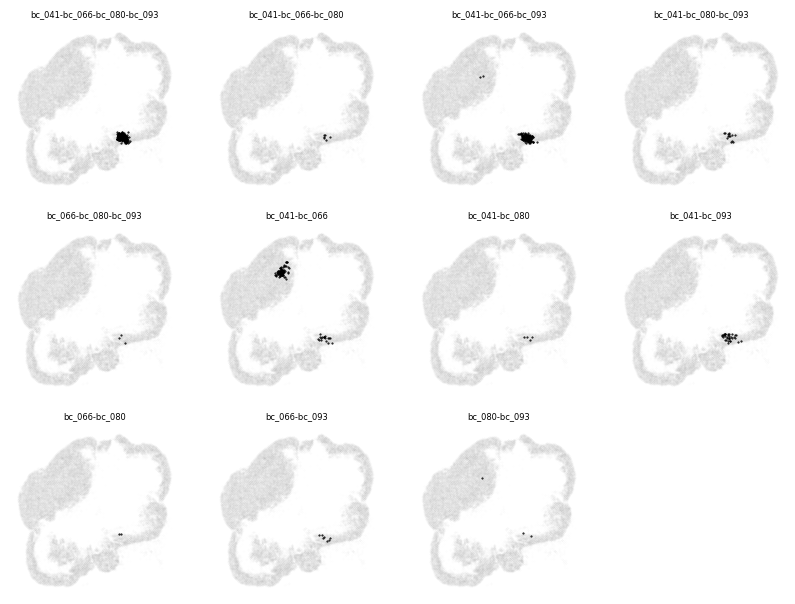

In [156]:
bc_list = ['bc_041','bc_066','bc_080','bc_093']

# import  as comb
bcs_here = []
bcs_here.append('-'.join(bc_list))
for c in itertools.combinations(bc_list,3):
    bcs_here.append('-'.join(c))

for c in itertools.combinations(bc_list,2):
    bcs_here.append('-'.join(c))

plt.figure(figsize=(10,10))
for i,bc_name in enumerate(bcs_here):
    
    plt.subplot(4,4,i+1)
    plt.title(bc_name,fontsize=6)

    others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
            color='k',alpha=1.0,
            s=0.25)
    
    plt.axis('off')

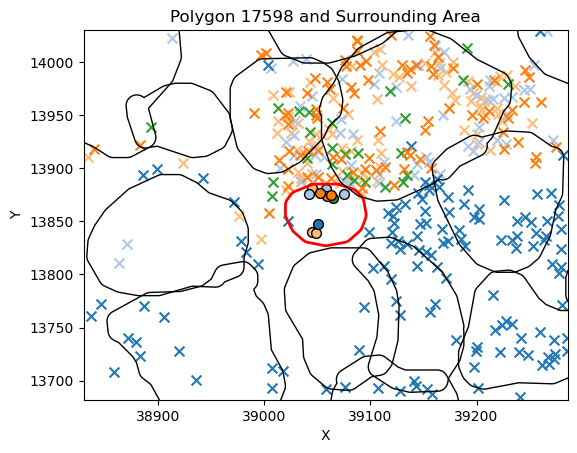

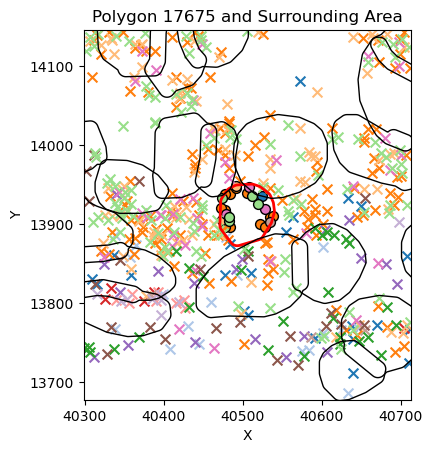

In [176]:
for cell_id in ['17598','17675']:
    # print(cell_id,mapping_dict[cell_id],df[df['cell_id']==cell_id]['called_barcodes'].values[0])

    region = get_polygons_around_polygon(sg_obj,cell_id,image_scale=5)

    gene_names = ['bc_041','bc_066','bc_080','bc_093']

    gene_names = get_all_barcodes_in_region(df,region['object_id'].values)

    # print(gene_names)

    # gene_names = df[df['cell_id']==cell_id]['called_barcodes'].values[0] + df[df['cell_id']=='60']['called_barcodes'].values[0]

    sg_obj.plot_polygon_and_points(cell_id,gene_names=gene_names,annotate=False,image_scale=5)
    # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)

In [ ]:
## Do cells with the same barcode tend to belong to one cluster or the other?"

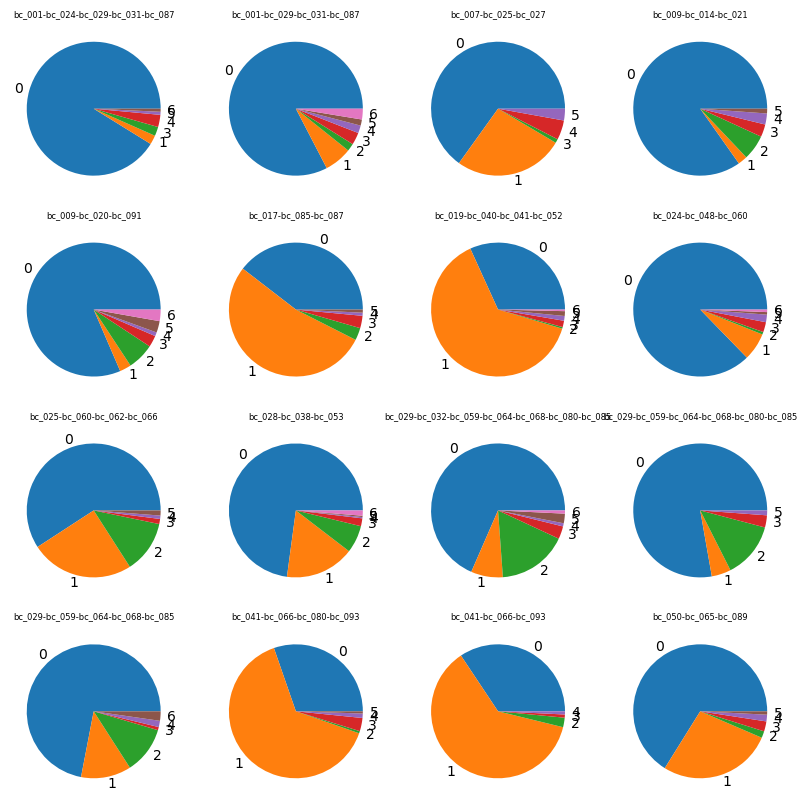

In [504]:

plt.figure(figsize=(10,10))
for i,bc_name in enumerate(very_common_bcs):
    
    plt.subplot(4,4,i+1)
    plt.title(bc_name,fontsize=6)

    # others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    # plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
    #         color='gray',alpha=0.01,
    #         s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    clusters,sizes = np.unique(this_bc.obs[f'leiden_res_{res_to_use:4.2f}'],return_counts=True)

    plt.pie(sizes,labels=clusters)

    
    # plt.subplot(4,4,i+1)
    # plt.title(bc_name,fontsize=6)

    # others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    # plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
    #         color='gray',alpha=0.01,
    #         s=0.1)

    

    # plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
    #         color=bc_color_dict[bc_name],alpha=1.0,
    #         s=0.25)
    
    # plt.axis('off')

In [516]:
bcs,counts= np.unique(adata_genes[adata_genes.obs['leiden_res_0.25']=='6'].obs['barcode_names'],return_counts=True)
[(b,c) for b,c in zip(bcs,counts) if (c>3 and b != '')]
          

[('bc_001-bc_029-bc_031-bc_087', 14),
 ('bc_001-bc_031-bc_087', 4),
 ('bc_002', 5),
 ('bc_009-bc_091', 4),
 ('bc_022', 15),
 ('bc_025-bc_079-bc_083', 5),
 ('bc_028-bc_038-bc_053', 4),
 ('bc_050', 4)]

In [519]:
bcs,counts= np.unique(adata_genes[adata_genes.obs['leiden_res_0.25']=='5'].obs['barcode_names'],return_counts=True)
[(b,c) for b,c in zip(bcs,counts) if (c>3 and b != '')]

[('bc_001-bc_029-bc_031-bc_087', 8),
 ('bc_020', 4),
 ('bc_022', 4),
 ('bc_048-bc_060', 4),
 ('bc_050', 9),
 ('bc_060', 4)]

In [515]:
bcs,counts= np.unique(adata_genes[adata_genes.obs['leiden_res_0.25']=='3'].obs['barcode_names'],return_counts=True)
[(b,c) for b,c in zip(bcs,counts) if (c>3 and b != '')]

[('bc_001', 7),
 ('bc_001-bc_029-bc_031-bc_087', 16),
 ('bc_002', 6),
 ('bc_002-bc_094', 5),
 ('bc_004-bc_050', 4),
 ('bc_006-bc_019-bc_064-bc_094', 4),
 ('bc_007-bc_013-bc_054-bc_060', 4),
 ('bc_009', 6),
 ('bc_009-bc_014-bc_021', 8),
 ('bc_009-bc_091', 7),
 ('bc_010-bc_060-bc_081', 4),
 ('bc_013-bc_060', 4),
 ('bc_017-bc_085-bc_087', 4),
 ('bc_019-bc_040-bc_041-bc_052', 4),
 ('bc_020', 11),
 ('bc_022', 26),
 ('bc_022-bc_033', 4),
 ('bc_024', 9),
 ('bc_024-bc_048-bc_060', 4),
 ('bc_025', 5),
 ('bc_028-bc_038-bc_053', 6),
 ('bc_029-bc_032-bc_059-bc_064-bc_068-bc_080-bc_085', 4),
 ('bc_029-bc_059-bc_064-bc_068-bc_080-bc_085', 5),
 ('bc_030-bc_040-bc_058-bc_059-bc_083-bc_095', 7),
 ('bc_033', 5),
 ('bc_033-bc_095', 7),
 ('bc_041-bc_045-bc_047-bc_052', 4),
 ('bc_041-bc_066-bc_080-bc_093', 6),
 ('bc_045', 7),
 ('bc_048-bc_060', 9),
 ('bc_050', 19),
 ('bc_052-bc_068', 4),
 ('bc_058-bc_083', 9),
 ('bc_060', 6),
 ('bc_060-bc_081', 12),
 ('bc_063', 6),
 ('bc_073', 5),
 ('bc_074', 6),
 ('bc_074

In [1]:
import itertools

In [87]:
dist = scipy.spatial.distance.pdist(df[barcode_cols].values,'braycurtis')   

KeyboardInterrupt: 

In [99]:
adata_genes[adata_genes.obs['leiden_res_0.25']=='9'].obs['barcode_names']

KeyError: 'leiden_res_0.25'